# Genetic for genomics

In this notebook, we aim at fininding the best set of hyper parametter for our different models.

We will start with a single type of model to keep things simple.


In [2]:
import sys
import importlib
import pickle
import random

# data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data analysis
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# pytorch specific
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# project specific
sys.path.append('../')
from src import config
from src.utils import visualisation, benchmark, helpers, monitoring, experiment, search
from src.models import model


from matplotlib.animation import FuncAnimation
from IPython.display import HTML

pd.options.display.width = 1000
DEVICE = torch.device(config["DEVICE"])

In [3]:
# We first set the parametters that we do no want to change

data_params = { 
    "LS_threshold" : 0.0023,
    "MAD_threshold" : 1, 
    "MT_removal" : True, 
    "expression_threshold" : 0.1}
# or we can use a pre loaded dataset to save time
data_params = '../workfiles/light_BRCA_ds.pkl'

model_params = {
    "convolution": False,
    "transformer" : True
    }



# This one is absurdly clumsy but that's the only way i could do it.

variational_param_ = {
    "variational": [ # constraint : embedding_dim <= num_embeddings
        (("embedding_dim", 16), ("num_embeddings", 64)),
        (("embedding_dim", 16), ("num_embeddings", 128)),
        (("embedding_dim", 16), ("num_embeddings", 256)),
        (("embedding_dim", 16), ("num_embeddings", 512)),
        (("embedding_dim", 32), ("num_embeddings", 64)),
        (("embedding_dim", 32), ("num_embeddings", 128)),
        (("embedding_dim", 32), ("num_embeddings", 256)),
        (("embedding_dim", 32), ("num_embeddings", 512)),
        (("embedding_dim", 64), ("num_embeddings", 64)),
        (("embedding_dim", 64), ("num_embeddings", 128)),
        (("embedding_dim", 64), ("num_embeddings", 256)),
        (("embedding_dim", 64), ("num_embeddings", 512)),
        (("embedding_dim", 128), ("num_embeddings", 128)),
        (("embedding_dim", 128), ("num_embeddings", 256)),
        (("embedding_dim", 128), ("num_embeddings", 512))]}




dynamic_params = {
    "dropout"       : [0.1, 0.3, 0.5],
    "n_epoch"       : [100, 500, 1000, 3000],
    "latent_dim"    : [16, 32, 64, 128],
    "latent_dim"    : [16, 32, 64, 128],
    "num_layers"    : [1,2,3,4,5,6,7],
    "variational" : [],
}




for commitment_cost in [0.2, 0.4, 0.6, 0.8, 1]:
    for (param1, param2) in variational_param_['variational']:
        dynamic_params["variational"].append((("variational", "VQ-VAE"),("commitment_cost", commitment_cost),param1, param2))

# we want to be as likely to pick a VQ-VAE, VAE or non variational model.
dynamic_params['variational'] = dynamic_params['variational'] + [None]*len(dynamic_params['variational']) + ["VAE"]*len(dynamic_params['variational'])

configurations = helpers.generate_config(model_params, dynamic_params)
print("number of config to be evaluated:",len(configurations))

all_config = helpers.generate_config(model_params, dynamic_params)
print(len(all_config))

number of config to be evaluated: 75600
75600


In [3]:
# Initialize GA parameters
population_size = 5

search_param = {
    "EPOCH": 1000,                            # wayy too low, would have to be tuned up
    "population_size" : population_size,    # this is very low for a genetic algo
    "mutation_rate" : 0.5,                  # Every run is so costly that we have to have an aggressively high value
    "crossover_rate" : 0.7,                 # usually high
    "generations" : 5                       # way too low for GA as well
    }


# Step 1: Create the initial population
population = random.sample(all_config, population_size)

In [4]:
s = search.genetic_search(
    search_param=search_param, 
    data_param=data_params, 
    model_param=model_params, 
    initial_population= population,
    dynamic_params=dynamic_params)

In [6]:
s.add_alternative_dataset("../workfiles/PPMI_genes.pkl")

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Running generation 1...
input shape : 3242
(1231, 3242)
(1231, 1, 3242)
train data: 1231
Running the following configuration:
../workfiles/light_BRCA_ds.pkl
{'variational': False, 'convolution': True, 'transformer': False, 'dropout': 0.5, 'padding': 3, 'kernel_size': 7}


100%|██████████| 12/12 [00:24<00:00,  2.05s/it]


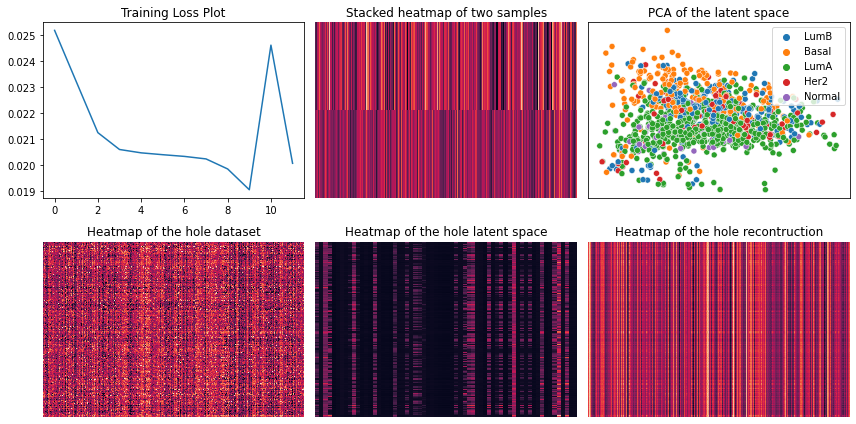

{'hopkins': 0.9339783116986977, 'ari': 0.04166342186358318, 'nmi': 0.06236585968076167, 'silhouette': 0.32069072, 'fm': 0.3180230062324399, 'homogeneity': 0.068207812907879, 'completeness': 0.057445676211717825, 'v_measure': 0.06236585968076167}
No change in best performer.
Best individual is still: {'variational': False, 'convolution': True, 'transformer': False, 'dropout': 0.3, 'padding': 3, 'kernel_size': 7} with metric: 0.15237153041183044
input shape : 6963
(1521, 6963)
(1521, 1, 6963)
train data: 1521
Running the following configuration:
../workfiles/PPMI_genes.pkl
{'variational': False, 'convolution': True, 'transformer': False, 'dropout': 0.5, 'padding': 3, 'kernel_size': 7}


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 12/12 [01:24<00:00,  7.03s/it]


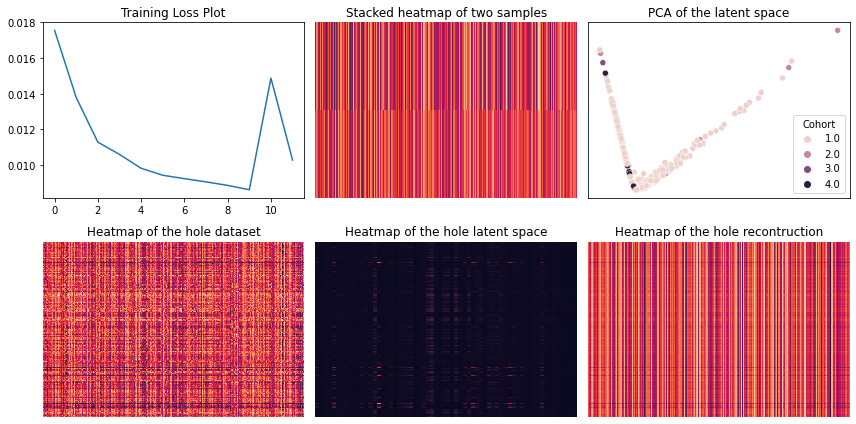

{'hopkins': 0.9839778522112552, 'ari': -0.0022509073658536533, 'nmi': 0.006312958269666899, 'silhouette': 0.4856541, 'fm': 0.5183375142810749, 'homogeneity': 0.008134729189471604, 'completeness': 0.005157857213332383, 'v_measure': 0.006312958269666899}
input shape : 3242
(1231, 3242)
(1231, 1, 3242)
train data: 1231
Running the following configuration:
../workfiles/light_BRCA_ds.pkl
{'variational': False, 'convolution': True, 'transformer': False, 'dropout': 0.3, 'padding': 3, 'kernel_size': 7}


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  8%|▊         | 1/12 [00:02<00:31,  2.90s/it]


KeyboardInterrupt: 

In [7]:
s.run()

In [7]:
type("self.data_param") == str

True

In [ ]:
print(s.best_performer)
print(s.best_performer_metric)
print(s.n_iter)
print(s.current_generation)


{'variational': False, 'convolution': True, 'transformer': False, 'dropout': 0.3, 'latent_dim': 16, 'padding': 2, 'kernel_size': 5}

0.26742224886270843

70

0